### 2D Electromagnetic Scattering Simulator using FEM

#### Imports

In [31]:
import calfem.geometry as cfg
import calfem.mesh as cfm
import calfem.vis_mpl as cfv
import numpy as np

#### Define Problem

In [32]:
g = cfg.Geometry()

g.point([0.0, 0.0])
g.point([1.0, 0.0])
g.point([1.0, 5.0])
g.point([0.0, 5.0])

g.spline([0, 1], marker=1)
g.spline([1, 2], marker=0)
g.spline([2, 3], marker=2)
g.spline([3, 0], marker=0)

g.surface([0, 1, 2, 3])

k0 = 5

#### Generate Mesh

In [33]:
def reshape_boundary_dict(bdofs):
    nodeset = set([0])
    for array in bdofs.items():
        nodeset.update(array[1])
    new = np.zeros(len(nodeset)-1, dtype="complex")
    for key in bdofs:
        for elem in bdofs[key]:
            new[elem-1] = key
    return new

In [34]:
mesh = cfm.GmshMesh(g)
mesh.elType = 2
mesh.dofsPerNode = 1
mesh.elSizeFactor = 0.1
coords, edof, dofs, bdofs, elementmarkers = mesh.create()
boundaries = reshape_boundary_dict(bdofs)

Info    : GMSH -> Python-module


#### Assemble Element Matrices

In [35]:
def Ke(coords, alpha_x, alpha_y):
    x1 = coords[0,0]
    x2 = coords[1,0]
    x3 = coords[2,0]
    y1 = coords[0,1]
    y2 = coords[1,1]
    y3 = coords[2,1]
    A = 1/2 * np.abs(x1*(y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2))
    M11 = -(alpha_x * (y2 - y3) ** 2  + alpha_y * (x3 - x2) ** 2) / (4 * A)
    M12 = -(alpha_x * (y2 - y3) * (y3 - y1) + alpha_y * (x3 - x2) * (x1 - x3)) / (4 * A)
    M13 = -(alpha_x * (y2 - y3) * (y1 - y2) + alpha_y * (x3 - x2) * (x2 - x1)) / (4 * A)
    M22 = -(alpha_x * (y3 - y1) ** 2 + alpha_y * (x1 - x3) ** 2) / (4 * A)
    M23 = -(alpha_x * (y3 - y1) * (y1 - y2) + alpha_y * (x1 - x3) * (x2 - x1)) / (4 * A)
    M33 = -(alpha_x * (y1 - y2) ** 2 + alpha_y * (x2 - x1) ** 2) / (4 * A)
    return np.matrix([[M11, M12, M13],
                      [M12, M22, M23],
                      [M13, M23, M33]], dtype="complex")

In [36]:
def Te(coords, beta):
    x1 = coords[0,0]
    x2 = coords[1,0]
    x3 = coords[2,0]
    y1 = coords[0,1]
    y2 = coords[1,1]
    y3 = coords[2,1]
    A = 1/2 * np.abs(x1*(y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2))
    T1 = beta*A/6
    T2 = beta*A/12
    return np.matrix([[T1, T2, T2],
                      [T2, T1, T2],
                      [T2, T2, T1]], dtype="complex")

In [37]:
def pe(coords, gamma, is_open):
    if not is_open:
        return np.matrix([[0, 0, 0],
                          [0, 0, 0],
                          [0, 0, 0]], dtype="complex")
    x1 = coords[0,0]
    x2 = coords[1,0]
    y1 = coords[0,1]
    y2 = coords[1,1]
    l12 = np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
    k11 = -gamma * l12 / 3
    k12 = -gamma * l12 / 6
    return np.matrix([[k11, k12, 0],
                      [k12, k11, 0],
                      [0  , 0  , 0]], dtype="complex")

In [38]:
num_elem = len(edof)
num_nodes = len(dofs)
ke = np.zeros((num_elem, 3, 3), dtype="complex")
be = np.zeros((num_elem, 3), dtype="complex")
for i in range(num_elem):
    is_open = False
    if (edof[i][0] <= len(boundaries) and boundaries[edof[i][0] - 1] == 2):
        is_open = True
    ke[i] = Ke(coords[edof[i] - 1], 1, 1) + Te(coords[edof[i] - 1], k0**2) + pe(coords[edof[i] - 1], 1j*k0, is_open)

#### Assemble Global Matrix

In [39]:
K = np.zeros((num_nodes, num_nodes), dtype="complex")
for e in range(num_elem):
    for i in range(3):
        for j in range(3):
            K[edof[e,i] - 1, edof[e,j] - 1] += ke[e,i,j]

#### Create RHS Vector

In [40]:
b = np.zeros(num_nodes, dtype=complex)

#### Introduce Boundary Conditions

In [41]:
for n in reversed (range(len(boundaries))):
    if int(np.real(boundaries[n])) == 2:
        continue
    for i in range(len(b)):
        b[i] -= boundaries[n]*K[i, n]
    b = np.delete(b, n, axis=0)
    K = np.delete(K, n, axis=0)
    K = np.delete(K, n, axis=1)

#### Solve

In [42]:
x = np.linalg.solve(K,b)

#### Cleanup Results

In [43]:
abc_i = 0
for i in range(len(boundaries)):
    if boundaries[i] == 2:
        boundaries[i] = x[abc_i]
        abc_i+=1
v = np.concatenate((boundaries,x[abc_i:]))

#### Plot

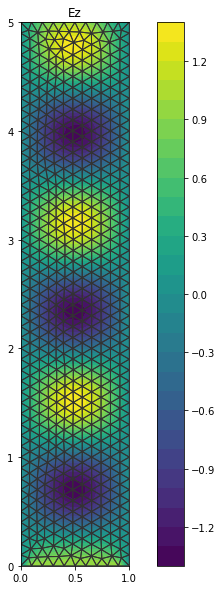

In [46]:
cfv.figure(fig_size=(10,10))
cfv.draw_nodal_values_contourf(np.real(v), coords, edof, title="Ez", dofs_per_node=mesh.dofs_per_node, el_type=mesh.el_type, draw_elements=True, levels=30)
cfv.colorbar();